In [1]:
from augur.utils import read_node_data
import Bio.SeqIO
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.manifold import MDS, TSNE
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from Bio import SeqIO
from Helpers import get_hamming_distances, get_euclidean_data_frame

%matplotlib inline

## Define inputs, outputs, and parameters

In [2]:
sequences_path = "../seasonal-flu-nextstrain/results/aligned.fasta"
clades_path = "../seasonal-flu-nextstrain/results/clades.json"
dropped_strains = "../seasonal-flu-nextstrain/config/outliers_h3n2.txt"
tree_path = "../seasonal-flu-nextstrain/auspice/flu_seasonal_h3n2_ha_2y.json"
clades_to_plot = ['3c3.A', 'A3', 'A2/re', 'A2', 'A1b/135N', 'A1b/131K', 'A1b/94N', 'A1b/131K', 'A1b/197R', 'A1b/135K', 'A1b/137F', 'A1b/186D']

In [3]:
outlier_strains =  [line.rstrip('\n') for line in open(dropped_strains,"r")]

## Load genome sequences

In [4]:
#work on making this work
strains = []
genomes = []
for record in SeqIO.parse(sequences_path, "fasta"):
    if(record.id not in dropped_strains):
        strains.append(str(record.id))
        genomes.append(str(record.seq))

In [5]:
#### Checking to make sure the file I picked is a aligned Fasta file / is the file I wanted

len(strains)
print(len(genomes[0]) == len(genomes[1]))
print(len(genomes))

True
1168


In [6]:
strains[:5]

['U26830.1',
 'A/Shiraz/1006/2015',
 'A/Alabama/04/2017',
 'A/Brisbane/101/2017',
 'A/Texas/93/2017']

In [7]:
genomes_df = pd.DataFrame(genomes)
strains_df = pd.DataFrame(strains)

genomes_df.columns = ["strains"]
strains_df.columns = ["strains"]

In [8]:
genomes = genomes_df["strains"].values.tolist()

strains = strains_df["strains"].values.tolist()

## Calculate distance matrix

In [9]:
hamming_distances = get_hamming_distances(
    genomes
)
distance_matrix = squareform(hamming_distances)

In [10]:
distance_matrix.shape

(1168, 1168)

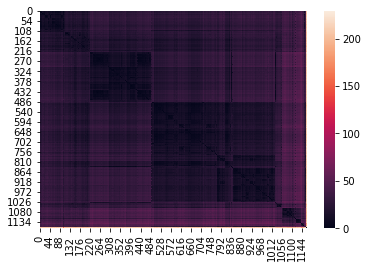

In [11]:
sns.heatmap(distance_matrix)

In [12]:
distance_matrix = pd.DataFrame(
    distance_matrix,
    columns=strains,
    index=strains
)

# Creating outliers

In [13]:
import re

In [14]:
genomes_missing_bases = []
for x in genomes:
    x = re.sub(r'[^AGCT]', '5', x)
    numberOfN = x.count("5")
    genomes_missing_bases.append(numberOfN)

In [15]:
genomes_missing_bases_df = pd.DataFrame(genomes_missing_bases)
genomes_missing_bases_df = genomes_missing_bases_df.merge(strains_df, how='outer', left_index = True, right_index = True)
genomes_missing_bases_df.columns = ["bases missing", "strain"]

In [16]:
# Also, consider storing the list of dropped strains in a text file outside of the notebook.
outlier_strains.extend(list(genomes_missing_bases_df[genomes_missing_bases_df["bases missing"]>1000]["strain"]))
mean_distances = distance_matrix.mean().reset_index(name="mean_distance").rename(columns={"index": "strain"})
outlier_strains.extend(mean_distances.query("mean_distance>52.5")["strain"].drop_duplicates()) #this number changes to be Q3 * 1.5 - automate this

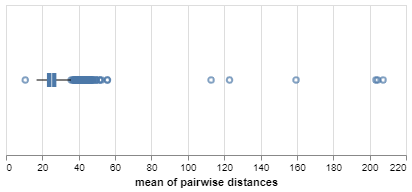

In [17]:
import altair as alt
alt.Chart(mean_distances, height=150).mark_boxplot().encode(
    x = alt.X('mean_distance', title="mean of pairwise distances"),
    tooltip = ["strain"]
)

In [18]:
# Build a data frame of clade annotations per strain in the same order
# as the sequences and the subsequent distance matrix.
outlier_annotations = pd.DataFrame([
    {"strain": strain}
    for strain in strains
])
outlier_annotations["outlier_status"] = outlier_annotations["strain"].isin(outlier_strains)

In [19]:
outlier_annotations["outlier_status"].value_counts()

False    1160
True        8
Name: outlier_status, dtype: int64

# Creating the Phylogenetic Tree in Altair
- I used Altair to make this tree (Documentation linked [here][1]
- The data from the JSON and the Data from the tree are usually a little different, so after merging the two dataframes you may get some errors.

[1]: https://altair-viz.github.io/index.html

In [20]:
from augur.utils import json_to_tree
import json
from Helpers import get_y_positions

In [21]:
with open(tree_path) as fh:
    json_tree_handle = json.load(fh)

In [22]:
tree = json_to_tree(json_tree_handle)

In [23]:
tree

Clade(branch_length=0, name='NODE_0000000')

In [24]:
heights = get_y_positions(tree)
for node in tree.find_clades():
    node.yvalue = heights[node]

In [25]:
node_data = [
    {
        "strain": node.name,
        "date": node.node_attrs["num_date"]["value"],
        "y": node.yvalue,
        "region": node.node_attrs["region"]["value"],
        "country": node.node_attrs["country"]["value"],
        "parent_date": node.parent is not None and node.parent.node_attrs["num_date"]["value"] or node.node_attrs["num_date"],
        "parent_y": node.parent is not None and node.parent.yvalue or node.yvalue,
        "clade_membership" : node.node_attrs['clade_membership']["value"]
    }
    for node in tree.find_clades(terminal=True)
]

In [26]:
node_data[10]

{'strain': 'A/Chungbuk/107/2016',
 'date': 2016.0478142076502,
 'y': 11,
 'region': 'N',
 'country': 'South Korea',
 'parent_date': 2015.1002971538403,
 'parent_y': 16.864990234375,
 'clade_membership': '3c3'}

In [27]:
node_df = pd.DataFrame(node_data)

In [28]:
node_df.head()

,strain,date,y,region,country,parent_date,parent_y,clade_membership
0,A/environment/Indiana/16TOSU3767/2016,2016.498634,1,N,USA,2015.977810,1.75000,unassigned
1,A/environment/Indiana/16TOSU3546/2016,2016.416667,2,N,USA,2016.306072,2.50000,unassigned
2,A/environment/Indiana/16TOSU3553/2016,2016.416667,3,N,USA,2016.306072,2.50000,unassigned
3,A/Guangdong/YueFang277/2017,2017.245205,4,N,China,2006.857507,18.96322,A1b/137F
4,A/Shiraz/1001/2015,2015.752055,5,N,Iran,2014.517341,5.50000,unassigned


In [29]:
node_df["y"] = node_df["y"].max() - node_df["y"]

In [30]:
node_df["parent_y"] = node_df["parent_y"].max() - node_df["parent_y"]

In [31]:
node_df.shape

(1156, 8)

In [32]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

In [33]:
indices_to_drop = distance_matrix[~distance_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
distance_matrix = distance_matrix[distance_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
distance_matrix = distance_matrix.drop(indices_to_drop.index, axis=1)
distance_matrix

,A/Alabama/04/2017,A/Brisbane/101/2017,A/Texas/93/2017,A/Brisbane/290/2016,A/Sydney/76/2017,A/Minnesota/85/2016,A/Ohio/31/2017,A/Ohio/33/2017,A/Sydney/34/2017,A/Darwin/1005/2017,...,A/India/1732610/2017,A/India/1733862/2017,A/India/1736032/2017,A/India/1736023/2017,A/Kenya/013/2017,A/MUWRP-Uganda/579/2016,A/Guangdong/YueFang277/2017,A/environment/Indiana/16TOSU3546/2016,A/environment/Indiana/16TOSU3767/2016,A/environment/Indiana/16TOSU3553/2016
A/Alabama/04/2017,0,13,12,9,8,6,8,9,10,11,...,50,45,40,41,44,41,123,205,208,204
A/Brisbane/101/2017,13,0,5,8,7,9,9,10,9,11,...,49,43,39,40,43,38,121,204,207,203
A/Texas/93/2017,12,5,0,7,6,8,8,9,8,10,...,48,43,38,39,42,39,120,203,206,202
A/Brisbane/290/2016,9,8,7,0,3,5,5,6,5,7,...,45,40,35,36,39,36,122,204,207,203
A/Sydney/76/2017,8,7,6,3,0,4,4,5,4,6,...,44,39,34,35,38,35,121,203,206,202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A/MUWRP-Uganda/579/2016,41,38,39,36,35,37,37,38,35,39,...,67,60,57,56,59,0,121,199,202,198
A/Guangdong/YueFang277/2017,123,121,120,122,121,119,120,121,123,123,...,145,140,132,131,140,121,0,215,218,214
A/environment/Indiana/16TOSU3546/2016,205,204,203,204,203,201,203,204,205,202,...,226,219,215,215,214,199,215,0,7,1
A/environment/Indiana/16TOSU3767/2016,208,207,206,207,206,204,206,207,208,205,...,229,222,218,218,218,202,218,7,0,6


In [34]:
# classify these "outliers" in another color? Make outlier strains categorical (if it's in this and its not an outlier, diff color)

# TSNE

In [35]:
from Helpers import get_euclidean_data_frame, get_hamming_distances, linking_tree_with_plots_brush
from Helpers import linking_tree_with_plots_clickable
from Helpers import scatterplot_xyvalues, scatterplot_tooltips, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

In [36]:
embedding = TSNE(n_components=2,metric='precomputed',perplexity = 25.95)
X_transformed_tsne = embedding.fit_transform(distance_matrix)

TSNE_df = pd.DataFrame(X_transformed_tsne,columns=['TSNE' + str(i) for i in range(1,3)])

TSNE_df["strain"] = distance_matrix.index

merged_tsne_df = TSNE_df.merge(node_df, on="strain")
merged_tsne_df = merged_tsne_df.merge(outlier_annotations, on="strain")

In [42]:
merged_tsne_df["outlier_status"].value_counts()

False    1152
True        4
Name: outlier_status, dtype: int64

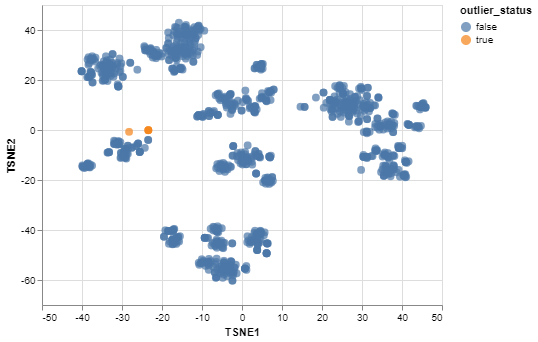

In [43]:
scatterplot_with_tooltip_interactive(merged_tsne_df,'TSNE1','TSNE2',"TSNE1","TSNE2",['strain','clade_membership'],'outlier_status')

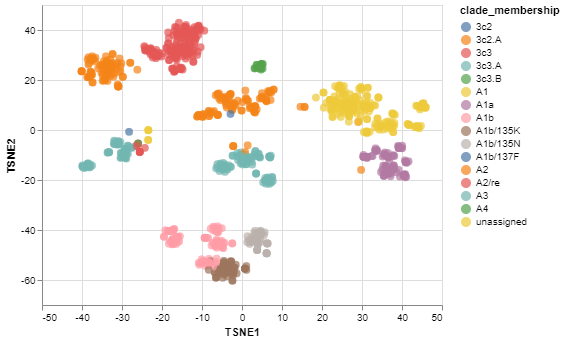

In [44]:
scatterplot_with_tooltip_interactive(merged_tsne_df,'TSNE1','TSNE2',"TSNE1","TSNE2",['strain','outlier_status'],'clade_membership')

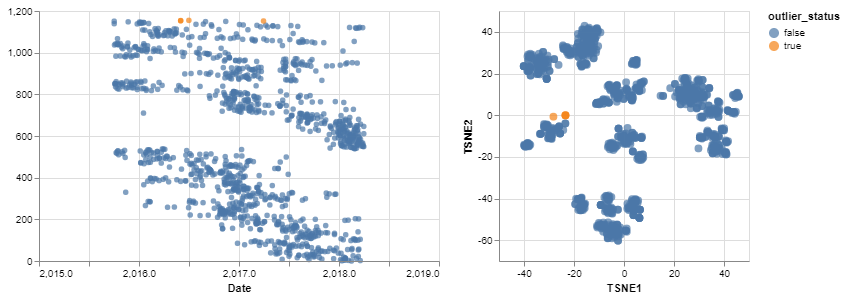

In [45]:
list_of_chart = linking_tree_with_plots_brush(
    merged_tsne_df,
    ['TSNE1','TSNE2'],
    ['TSNE1','TSNE2'],
    'outlier_status',
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart


In [46]:
# TODO: run classifier, generate desity plot, confusion matrix, test validity, send to John and push to git

## Assign sequences to k-fold groups and analyze each fold

For each fold, use the training indices to subset the distance matrix to just those columns and rows that belong in the training data. Apply a given embedding method to the distance matrix subset, identify the classification threshold for clade membership, and validate that threshold on the subset of the distance matrix corresponding to the validation indices.

In [47]:
# TODO: In practice we will want to iterate over all combinations of parameters
# for all embedding methods and also support PCA (which does not use a distance matrix as input).
embedding_class = TSNE
embedding_parameters = {
    "metric": "precomputed",
    "perplexity": 30,
    "learning_rate": 500
}

In [48]:
embedding_class = UMAP
embedding_parameters = {
    "n_neighbors": 20,
    "min_dist": 0.5,
    "n_components": 2,
    "init": "spectral"
}

In [49]:
embedding_class = MDS
embedding_parameters = {
    "dissimilarity": "precomputed"
}

In [50]:
fold_factory = KFold(n_splits=5, shuffle=True)
folds = fold_factory.split(distance_matrix.index)

In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression

In [57]:
def assign_outliers(outlier_annotations,index):
    outlier_status = []
    outlier_annotations = np.array(outlier_annotations["outlier_status"])
    print(len(np.take(outlier_annotations, index)))
    return np.take(outlier_annotations, index)

In [58]:
def create_mean_values(distance_matrix, index):
    mean_distance_matrix  = pd.DataFrame()
    mean_distance_matrix["mean"] = distance_matrix.mean(axis=1)
    return np.take(np.array(mean_distance_matrix), index)

In [59]:
distance_matrix = np.array(distance_matrix)
#np.take(distance_matrix_array, training_index)

In [62]:
# TODO: consider adding support for an exhaustive grid search of parameters 
# for different embeddings and the classifier:
# https://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search
genetic_accuracies = []
accuracies = []
classifier_thresholds = []
confusion_matrices = []
matthews_cc = []
for k, (training_index, validation_index) in enumerate(folds): 
    print(f"Fit to fold: {k}")
    # Subset distance matrix to training indices.
    training_distance_matrix = distance_matrix[training_index][:, training_index]
    
    # Embed training distance matrix.
    
    embedder = embedding_class(**embedding_parameters)
    
    training_embedding = embedder.fit_transform(training_distance_matrix)
    
    training_embedding_distances = pdist(training_embedding)
    
    training_embedding_distances = squareform(training_embedding_distances).reshape(-1, 1)
    
    training_embedding_distances = np.reshape(training_embedding_distances, (len(training_index), len(training_index)))
    

    # Assign a binary class to each pair of samples based on their clade memberships.
    # Samples from different clades are assigned 0, samples from the same clade as assigned 1.
    # This vector of binary values will be the output to fit a classifier to.
    # These pairs should be in the same order as the embedding distances above.      
          
    training_outlier_status_for_pairs = assign_outliers(
        outlier_annotations,
        training_index
    )
    
    # Use a support vector machine classifier to identify an optimal threshold
    # to distinguish between within and between class pairs.
    # See also: https://scikit-learn.org/stable/modules/svm.html#svm-classification
    classifier = make_pipeline(
        StandardScaler(),
        LogisticRegression(solver='lbfgs', max_iter=7600)
        #LinearSVC(random_state=0, tol=1e-5, dual = True, max_iter = 10000)
    )

    classifier.fit(training_embedding_distances, training_outlier_status_for_pairs)
    
    classifier_threshold = (0.5 - classifier.named_steps["lbfgs"].intercept_) / classifier.named_steps["lbfgs"].coef_[0]
    classifier_thresholds.append(classifier_threshold)

Fit to fold: 0
925


KeyError: 'lbfgs'

In [ ]:
    # Use a SVM to identify an optimal threshold for genetic distances.
    genetic_classifier = make_pipeline(
        StandardScaler(),
        LinearSVC(random_state=0, tol=1e-5)
    )
    genetic_classifier.fit(squareform(training_distance_matrix).reshape(-1, 1), training_clade_status_for_pairs)
    
    # Subset distance matrix to validation indices.
    validation_distance_matrix = distance_matrix[validation_index][:, validation_index]
    
    # Embed validation distance matrix.
    validation_embedding = embedder.fit_transform(validation_distance_matrix)
    
    # Calculate Euclidean distance between pairs of samples in the embedding.
    # The output should be a data frame of distances between pairs.
    validation_embedding_distances = pdist(validation_embedding).reshape(-1, 1)
    
    # Assign a binary class to each pair of samples based on their clade memberships.
    # Samples from different clades are assigned 0, samples from the same clade as assigned 1.
    # This vector of binary values will be the output to fit a classifier to.
    # These pairs should be in the same order as the embedding distances above.
    validation_clade_status_for_pairs = assign_outliers(
        clade_annotations,
        validation_index
    )

    # Predict and score clade status from embedding distances and the trained classifier.
    # The first argument is the set to predict classifier labels for. The second argument
    # is the list of true labels. The return argument is the mean accuracy of the predicted
    # labels.
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.score
    confusion_matrices.append(confusion_matrix(classifier.predict(validation_embedding_distances), validation_clade_status_for_pairs))
    matthews_cc.append(matthews_corrcoef(classifier.predict(validation_embedding_distances), validation_clade_status_for_pairs))
    
    accuracy = classifier.score(
        validation_embedding_distances,
        validation_clade_status_for_pairs
    )
    print(f"Accuracy: {accuracy}")
    
    genetic_accuracy = genetic_classifier.score(
        squareform(validation_distance_matrix).reshape(-1, 1),
        validation_clade_status_for_pairs
    )
    print(f"Genetic accuracy: {genetic_accuracy}")
    print()
    
    accuracies.append(accuracy)
genetic_accuracies.append(genetic_accuracy)

In [ ]:
sns.heatmap(confusion_matrices[3], annot=True)

In [ ]:
training_embedding_df = pd.DataFrame(training_embedding, columns=["x", "y"])
training_embedding_df["clade"] = clade_annotations.loc[training_index, "clade"].values

In [ ]:
validation_embedding_df = pd.DataFrame(validation_embedding, columns=["x", "y"])
validation_embedding_df["clade"] = clade_annotations.loc[validation_index, "clade"].values

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot("x", "y", hue="clade", data=training_embedding_df, legend=False, ax=axes[0])
axes[0].set_title("Training")

sns.scatterplot("x", "y", hue="clade", data=validation_embedding_df, legend=False, ax=axes[1])
axes[1].set_title("Validation")

sns.despine()

In [ ]:
training_embedding_distances.shape

In [ ]:
training_clade_status_for_pairs.shape

In [ ]:
training_embedding_distances.flatten()

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit_transform(training_embedding_distances)

In [ ]:
distances_df = pd.DataFrame({"distance": training_embedding_distances.flatten(), "same_clade": training_clade_status_for_pairs.flatten()})

In [ ]:
distances_df.head()

In [ ]:
distances_df["scaled_distance"] = scaler.fit_transform(training_embedding_distances).flatten()

In [ ]:
distances_df["genetic_distance"] = squareform(training_distance_matrix)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax = sns.kdeplot(distances_df.query("same_clade == 1")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(distances_df.query("same_clade == 0")["scaled_distance"], label="Different clade", ax=ax)

for classifier_threshold in classifier_thresholds:
    ax.axvline(x=classifier_threshold, label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

ax = axes[1]
ax = sns.kdeplot(distances_df.query("same_clade == 1")["genetic_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(distances_df.query("same_clade == 0")["genetic_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Genetic distance")
ax.set_ylabel("KDE density")

sns.despine()

## Plot and summarize accuracies

In [ ]:
# Print the mean accuracy and stddev
print(f"Accuracy: {np.mean(accuracies)} +/- {np.std(accuracies)}")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bins = np.arange(0, 1.01, 0.05)

ax.hist(accuracies, bins=bins)

ax.axvline(
    x=np.mean(accuracies),
    label=f"Mean accuracy: {np.mean(accuracies):.2f} +/- {np.std(accuracies):.2f}",
    color="orange"
)

ax.set_xlabel("Accuracy of classifier")
ax.set_ylabel("Number of cross-validation folds")

ax.legend(frameon=False)

sns.despine()

## Plot classifier thresholds

The linear support vector classifier (SVC) produces an intercept and coefficient for a single feature that represents a line through the domain of the input data that classifies samples into "same clade" (1) or "different clade" (0). The midpoint between these classification labels (0.5) is useful for visualizing the placement of the SVC results. We calculate the value of the input domain that corresponds to this line by solving for $0.5 = mx + b$ where $x$ is the value of interest from the input domain.

Below we plot the resulting distribution of classifier thresholds across all *k* folds to get a sense of how consistent these values are across training sets. Note that the input data have been scaled to z-values (centered by their mean and divided by their standard deviation).

In [ ]:
classifier_thresholds = np.array(classifier_thresholds).flatten()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(classifier_thresholds.flatten(), bins=10)

ax.axvline(
    x=np.mean(classifier_thresholds),
    label=f"Mean classifier threshold: {np.mean(classifier_thresholds):.2f} +/- {np.std(classifier_thresholds):.2f}",
    color="orange"
)

ax.set_xlabel("Classifier threshold on scaled Euclidean distances")
ax.set_ylabel("Number of cross-validation folds")

ax.legend(frameon=False)

sns.despine()